In [28]:
import pandas as pd
import numpy as np
import re
import ast
import warnings
from datetime import datetime
from math import ceil

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from glm.glm import GLM
from glm.families import Gaussian, Bernoulli, Poisson, Gamma
import statsmodels.formula.api as smf
from pandas.tools.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from basis_expansions.basis_expansions import (Polynomial, LinearSpline)
from regression_tools.dftransformers import (ColumnSelector, Identity,FeatureUnion, MapFeature, Intercept)
from regression_tools.plotting_tools import (plot_univariate_smooth, bootstrap_train, display_coef,plot_bootstrap_coefs,
                                             plot_partial_depenence, plot_partial_dependences, predicteds_vs_actuals)

warnings.filterwarnings('ignore')

In [32]:
#_ = scatter_matrix(cdf, alpha=0.2, figsize=(20, 20), diagonal='kde')

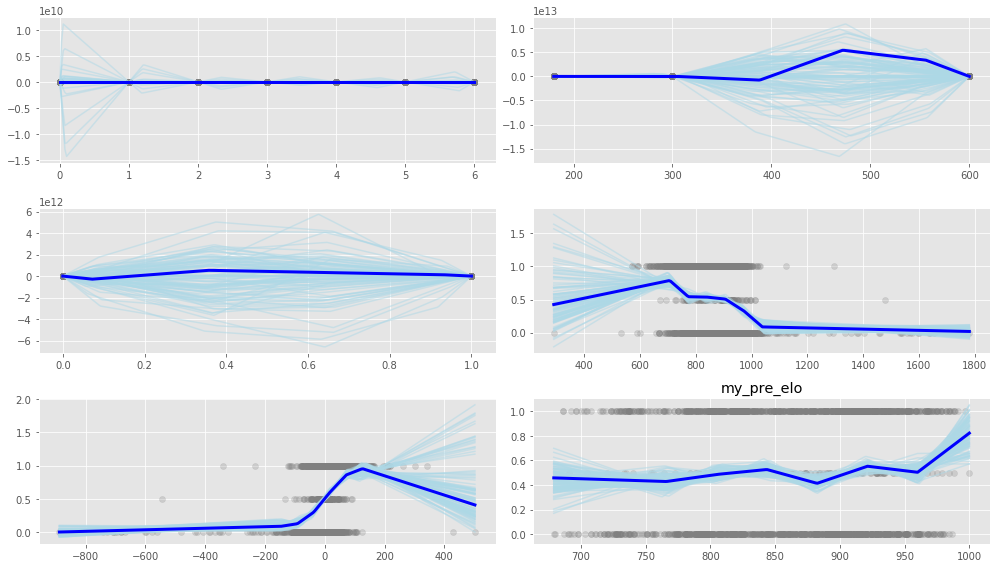

In [33]:
def plot_basis (axs, basis_expansion, t):
    basis = basis_expansion.fit_transform(t)
    for idx, ax in enumerate(axs.flatten()):
        ax.plot(t, basis[:, idx])

def  plot_one_univariate (ax, var_name, mask=None, bootstrap=100):
    if mask is None:
        plot_univariate_smooth(ax, cdf[var_name].values.reshape(-1, 1),
                               cdf['result'], bootstrap=bootstrap)
    else:
        plot_univariate_smooth(ax, cdf[var_name].values.reshape(-1, 1),
                               cdf['result'], mask=mask, bootstrap=bootstrap)

fig, axs = plt.subplots(3, 2, figsize=(14, 8))
univariate_plot_names = cdf.columns[:-1]

for name, ax in zip(univariate_plot_names, axs.flatten()):
    plot_univariate_smooth(ax,cdf[name].values.reshape(-1, 1),
                           cdf['result'], bootstrap=100)
ax.set_title(name)
fig.tight_layout()

In [34]:
day_fit = Pipeline([('day', ColumnSelector(name='day')),
                    ('day_spline', LinearSpline(knots=[0,1,2,3,4,5,6]))
                   ])
time_control_fit = Pipeline([('time_control', ColumnSelector(name='time_control')),
                             ('time_control_spline', LinearSpline(knots=[150,300,450,600]))
                            ])
my_color_fit = Pipeline([('my_color', ColumnSelector(name='my_color')),
                         ('my_color_spline', LinearSpline(knots=[0,1]))
                        ])
my_pre_elo_fit = Pipeline([('my_pre_elo', ColumnSelector(name='my_pre_elo')),
                           ('my_pre_elo_spline', LinearSpline(knots=[600,700,800,900,1000]))
                          ])
post_diff_fit = Pipeline([('post_diff', ColumnSelector(name='post_diff')),
                          ('post_diff_spline', LinearSpline(knots=[3,7,20,50,100,250,1000]))
                         ])
opp_post_elo_fit = Pipeline([('opp_post_elo', ColumnSelector(name='opp_post_elo')),
                             ('opp_post_elo_spline', LinearSpline(knots=[600,700,800,900,1000,1100,1300,1800]))
                            ])

day_fit.transform(cdf)
time_control_fit.transform(cdf)
my_color_fit.transform(cdf)
my_pre_elo_fit.transform(cdf)
post_diff_fit.transform(cdf)
opp_post_elo_fit.transform(cdf).head(1)

,opp_post_elo_spline_linear,opp_post_elo_spline_0,opp_post_elo_spline_1,opp_post_elo_spline_2,opp_post_elo_spline_3,opp_post_elo_spline_4,opp_post_elo_spline_5,opp_post_elo_spline_6,opp_post_elo_spline_7
0,1112.0,512.0,412.0,312.0,212.0,112.0,12.0,0.0,0.0


In [35]:
feature_pipeline = FeatureUnion([('intercept', Intercept()), ('day_fit', day_fit),
                                 ('time_control_fit', time_control_fit), ('my_color_fit', my_color_fit),
                                 ('my_pre_elo_fit', my_pre_elo_fit), ("post_diff_fit", post_diff_fit),
                                 ("opp_post_elo_fit", opp_post_elo_fit)
                                ])
feature_pipeline.fit(cdf)
features = feature_pipeline.transform(cdf)
model = LinearRegression(fit_intercept=False)
model.fit(features.values, y=cdf['result'])
model.predict(features.values)

array([-0.02813187,  1.15375141,  0.52239483, ...,  0.85928413,
        0.42358188,  0.93654664])

In [36]:
display_coef(model, features.columns)

Name                               Parameter Estimate  
-------------------------------------------------------
intercept                          -3.869585243482174e-05
day_spline_linear                  0.0020263707058478585
day_spline_0                       0.0020263707058460734
day_spline_1                       -0.019701319155325085
day_spline_2                       0.04682430625168837 
day_spline_3                       -0.10159444385179657
day_spline_4                       0.11000758056980373 
day_spline_5                       -0.04917851240124012
day_spline_6                       3.056582764671134e-15
time_control_spline_linear         -0.0030539633047920963
time_control_spline_0              0.0027504145604000554
time_control_spline_1              0.00033474178302685115
time_control_spline_2              0.00016737089151355915
time_control_spline_3              -1.5907414274707321e-15
my_color_spline_linear             0.033015581003508064
my_color_spline_0               

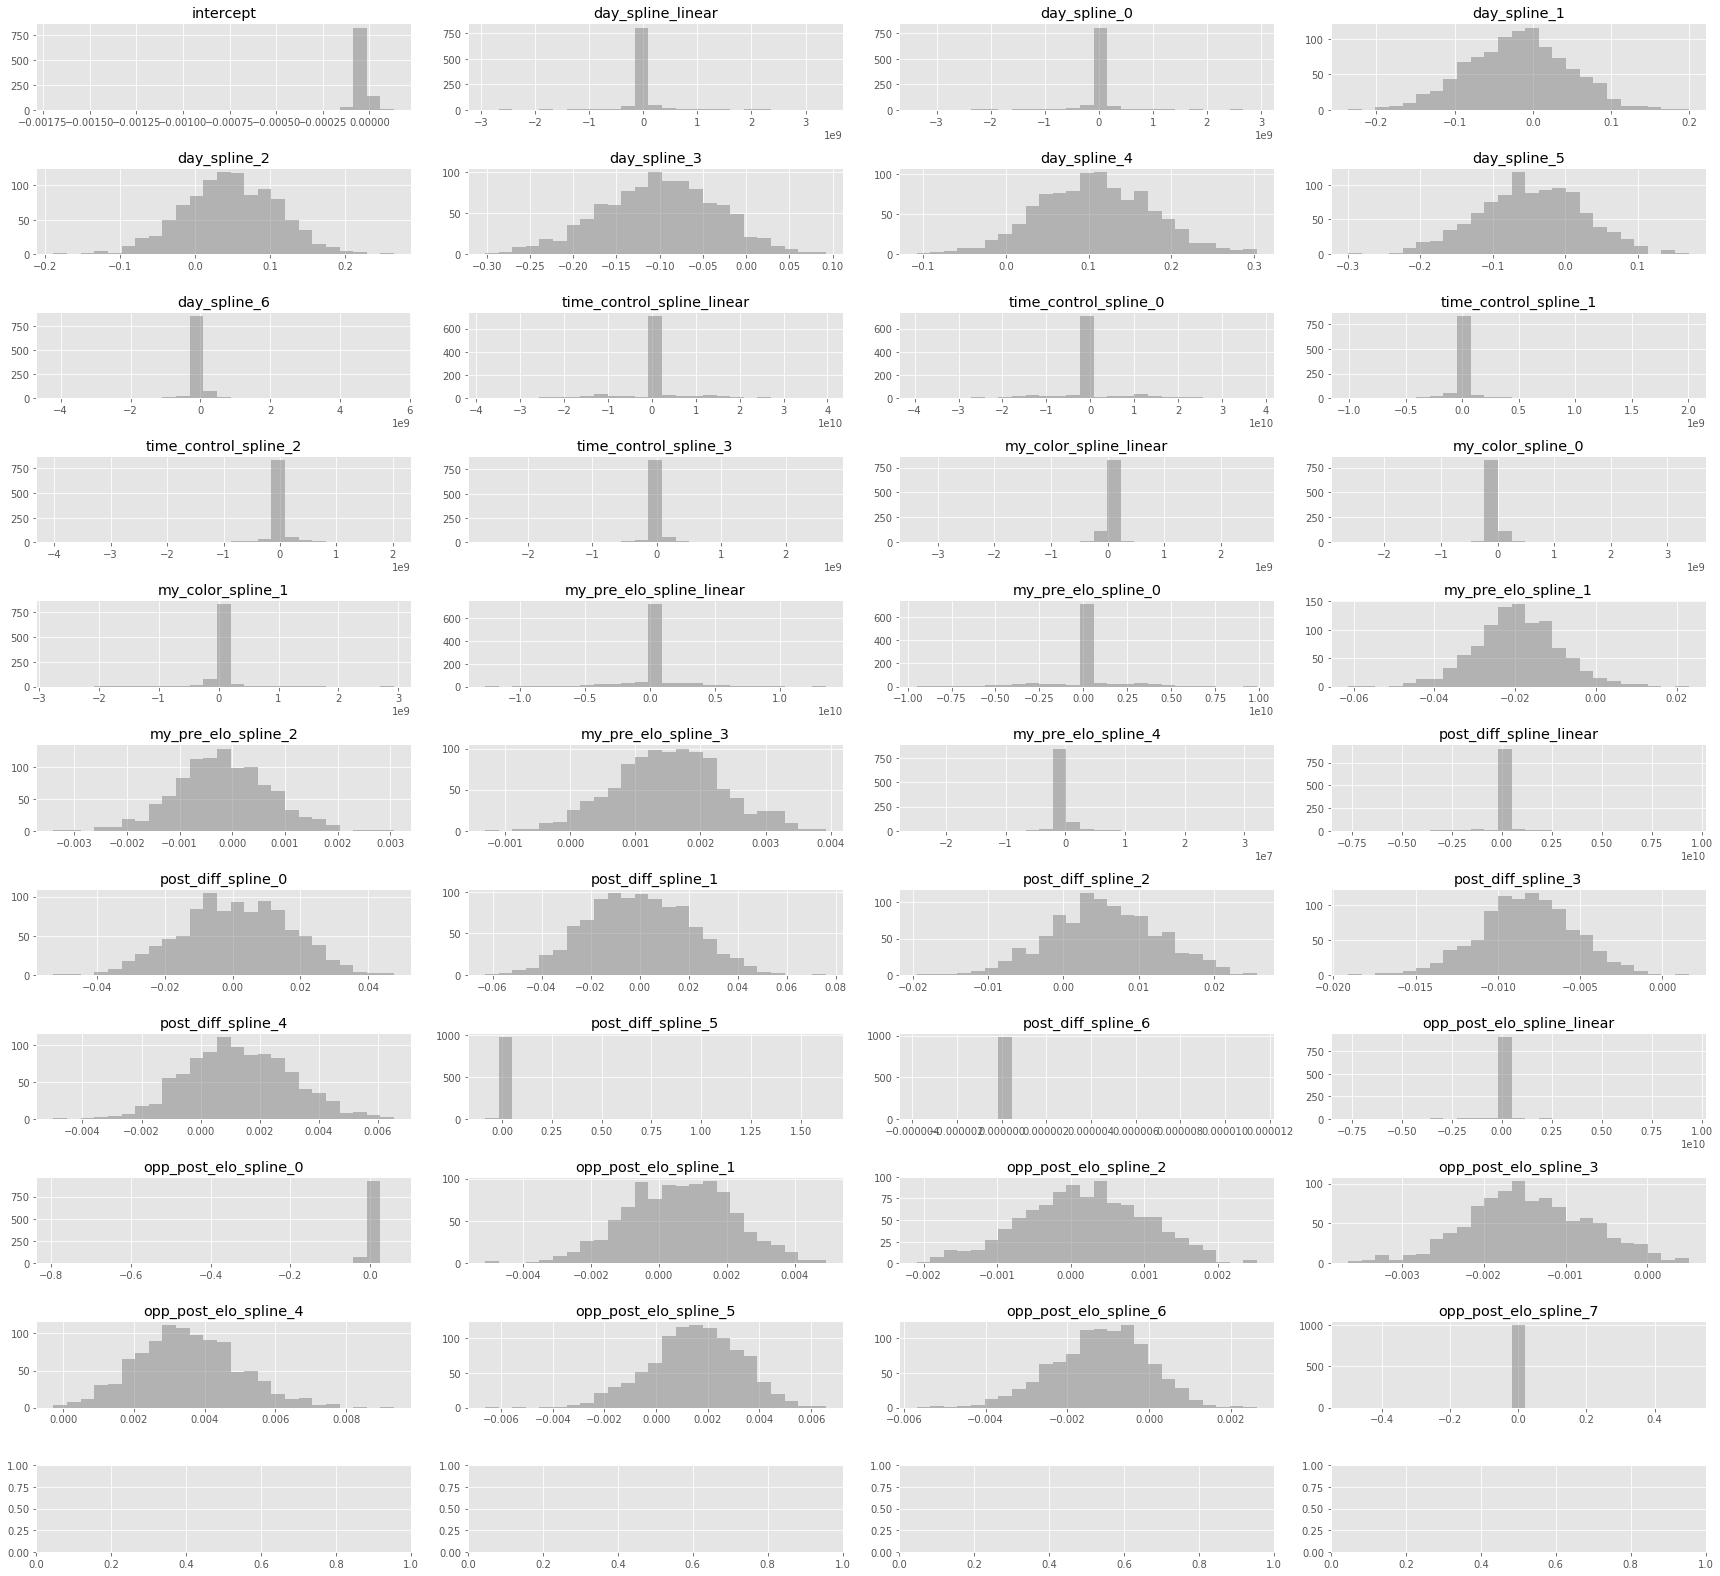

In [37]:
models = bootstrap_train(LinearRegression, features.values,
                         cdf['result'], fit_intercept=False
                        )
fig, axs = plot_bootstrap_coefs(models, features.columns, n_col=4)
fig.tight_layout()
plt.show()

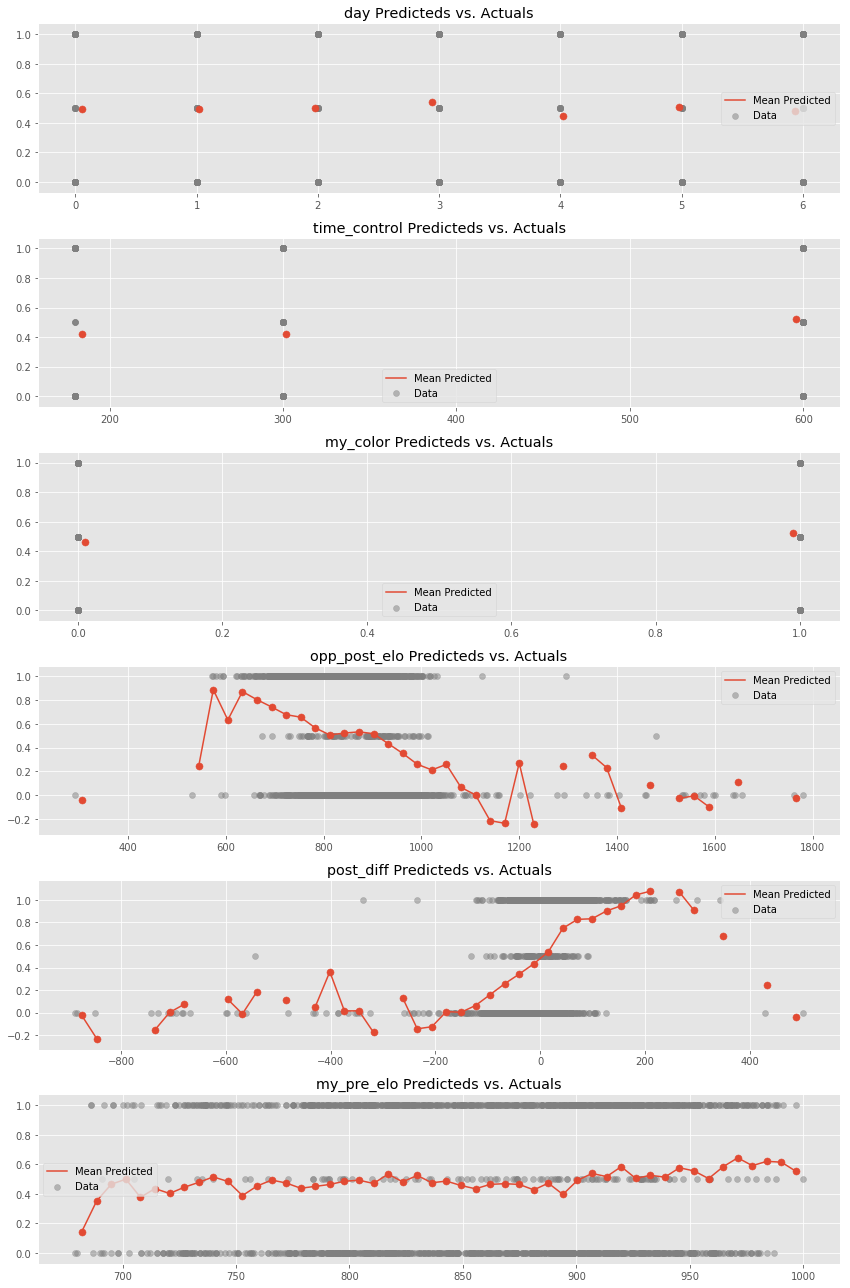

In [38]:
def  plot_many_predicteds_vs_actuals (var_names, y_hat, n_bins=50):
    fig, axs = plt.subplots(len(var_names), figsize=(12, 3*len(var_names)))
    for ax, name in zip(axs, var_names):
        x = cdf[name]
        predicteds_vs_actuals(ax, x, cdf["result"], y_hat, n_bins=n_bins)
        ax.set_title("{} Predicteds vs. Actuals".format(name))
    return fig, axs

var_names = ['day','time_control','my_color','opp_post_elo','post_diff','my_pre_elo']
y_hat = model.predict(features.values)
fig, axs = plot_many_predicteds_vs_actuals(var_names, y_hat)
fig.tight_layout()
plt.show()

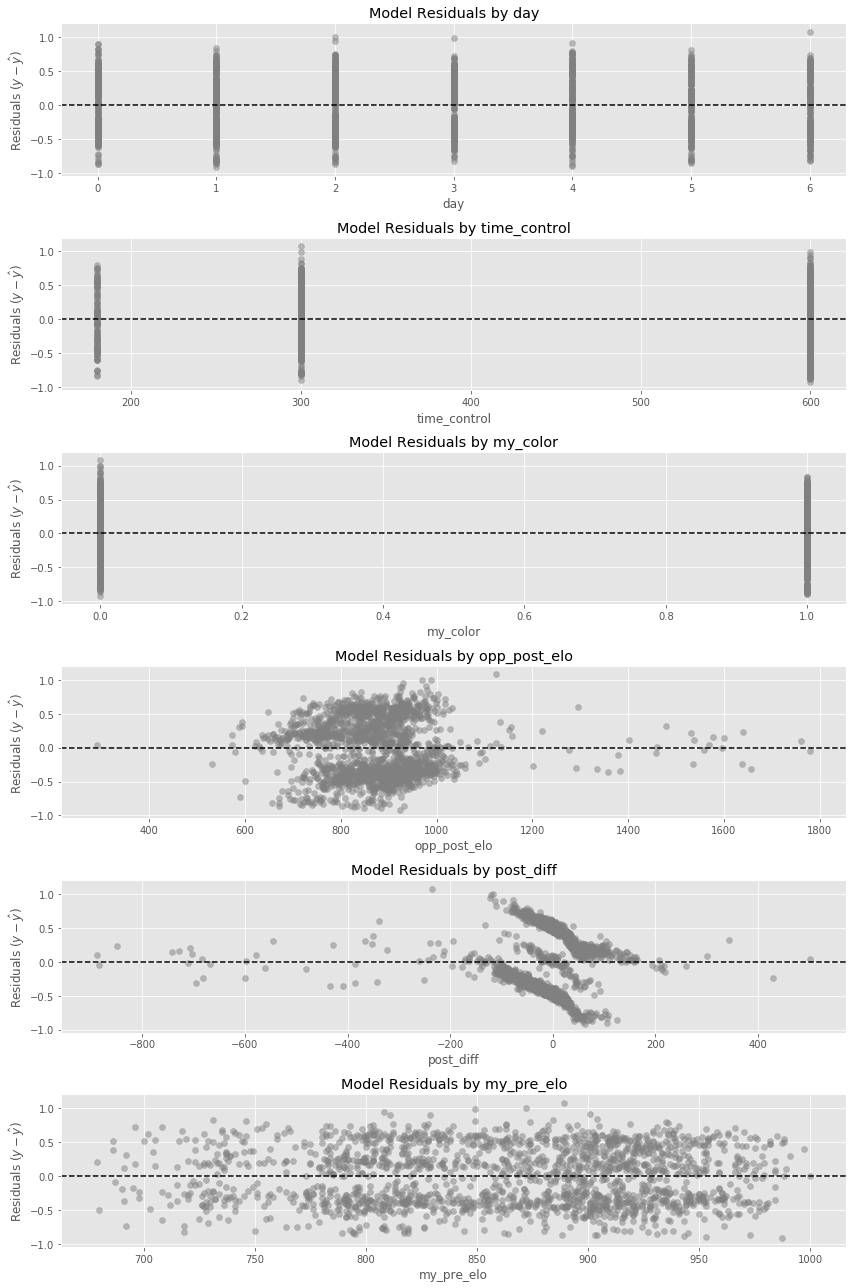

In [39]:
def residual_plot(ax, x, y, y_hat, n_bins=50):
    residuals = y - y_hat
    ax.axhline(0, color="black", linestyle="--")
    ax.scatter(x, residuals, color="grey", alpha=0.5)
    ax.set_ylabel("Residuals ($y - \hat y$)")

def plot_many_residuals(var_names, y_hat, n_bins=50):
    fig, axs = plt.subplots(len(var_names), figsize=(12, 3*len(var_names)))
    for ax, name in zip(axs, var_names):
        x = cdf[name]
        residual_plot(ax, x, cdf["result"], y_hat)
        ax.set_xlabel(name)
        ax.set_title("Model Residuals by {}".format(name))
    return fig, axs

var_names = ['day','time_control','my_color','opp_post_elo','post_diff','my_pre_elo']
fig, axs = plot_many_residuals(var_names, y_hat)
fig.tight_layout()
plt.show()

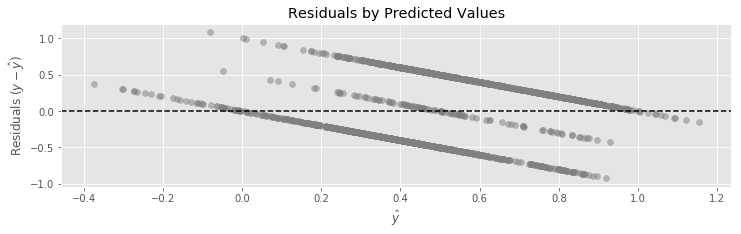

In [40]:
fig, ax = plt.subplots(figsize=(12, 3))
residual_plot(ax, y_hat, cdf["result"], y_hat)
ax.set_title("Residuals by Predicted Values")
ax.set_xlabel("$\hat y$")
plt.show()

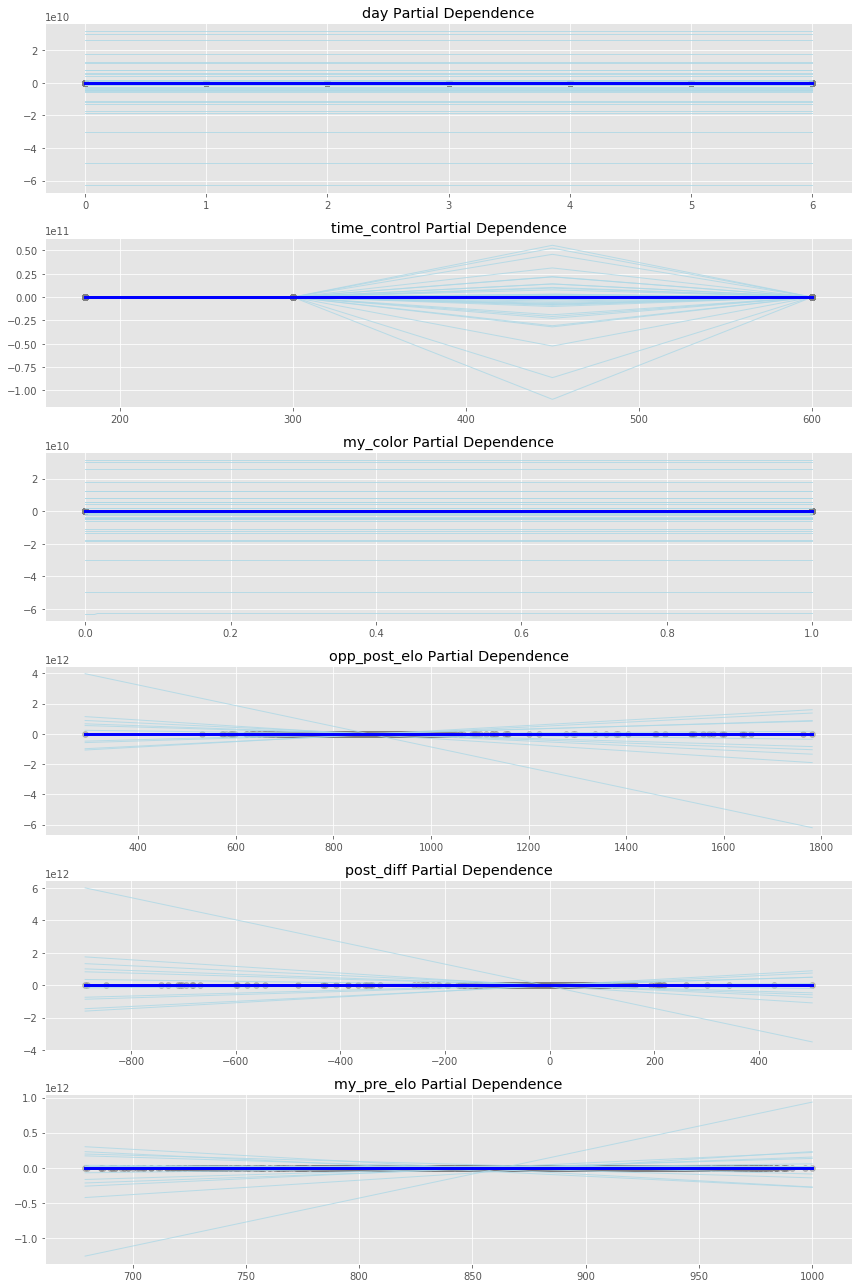

In [41]:
var_names = ['day','time_control','my_color','opp_post_elo','post_diff','my_pre_elo']
fig, axs = plot_partial_dependences(model, X=cdf, var_names=var_names, 
                                    pipeline=feature_pipeline, 
                                    bootstrap_models=models,y=cdf["result"]
                                   )
fig.tight_layout()
plt.show()